# Smart Meter Analysis Final Project

Michael Lee <br/>
CSCI E-63 Big Data Analytics Spring 2021

In [1]:
from pyspark.sql.functions import countDistinct, col, dayofweek, month, hour, minute, when
from pyspark.sql.functions import isnan, when, count, spark_partition_id, asc, desc, avg, to_date
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType, IntegerType, StringType, DateType
from pyspark.ml.feature import RFormula, VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor 
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.sql.functions import udf


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# citing https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot for reference

# set matplotlib plot font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Set SparkSession configuration

In [3]:
sc.setLogLevel("ERROR")

In [4]:
appName = "SmartMeter"
master = "local[8]"

spark = SparkSession.builder \
    .appName(appName) \
    .master(master) \
    .getOrCreate()

# Data Cleaning

## Load in Data

- Set Schemas for Imported Data

In [5]:
meter_daily_schema = StructType([StructField('LCLid', StringType(), True),
                                 StructField('time', DateType(), True),
                                 StructField('energy_median', FloatType(), True),
                                 StructField('energy_mean', FloatType(), True),
                                 StructField('max', FloatType(), True),
                                 StructField('energy_count', IntegerType(), True),
                                 StructField('std', FloatType(), True),
                                 StructField('energy_sum', FloatType(), True),
                                 StructField('min', FloatType(), True)])

In [6]:
meter_hourly_schema = StructType([StructField('LCLid', StringType(), True),
                                  StructField('time', TimestampType(), True),
                                  StructField('energy', FloatType(), True)])

In [7]:
household_schema = StructType([StructField('LCLid', StringType(), True),
                               StructField('stdorToU',StringType(), True),
                               StructField('Acorn',StringType(), True),
                               StructField('Socialeconomic',StringType(), True),
                               StructField('File', StringType(), True)])

In [8]:
weather_daily_schema = StructType([StructField('daily', FloatType(), True),
                                   StructField('tempMaxTime', TimestampType(), True),
                                   StructField('windDir', IntegerType(), True),
                                   StructField('icon', StringType(), True),
                                   StructField('dew', FloatType(), True),
                                   StructField('tempMinTime', TimestampType(), True),
                                   StructField('cloudCover', FloatType(), True),
                                   StructField('windSpd', FloatType(), True),
                                   StructField('pres', FloatType(), True),
                                   StructField('appTempMinTime', TimestampType(), True),
                                   StructField('appTempHigh', FloatType(), True),
                                   StructField('precip', StringType(), True),
                                   StructField('vis', FloatType(), True),
                                   StructField('humid', FloatType(), True),
                                   StructField('appTempHighTime', TimestampType(), True),
                                   StructField('appTempLow', FloatType(), True),
                                   StructField('appTempMax', FloatType(), True),
                                   StructField('uv', StringType(), True),
                                   StructField('time', DateType(), True),
                                   StructField('sunset', TimestampType(), True),
                                   StructField('tempLow', FloatType(), True),
                                   StructField('tempMin', FloatType(), True),
                                   StructField('tempHigh', FloatType(), True),
                                   StructField('sunrise', TimestampType(), True),
                                   StructField('tempHighTime', TimestampType(), True),
                                   StructField('uvIndexTime', TimestampType(), True),
                                   StructField('summary', StringType(), True),
                                   StructField('tempLowTime', TimestampType(), True),
                                   StructField('appTempMin', FloatType(), True),
                                   StructField('appTempMaxTime', TimestampType(), True),
                                   StructField('appTempLowTime', TimestampType(), True),
                                   StructField('moonPhase', FloatType(), True)])

In [9]:
weather_hourly_schema = StructType([StructField('vis', FloatType(), True),
                             StructField('windDir', IntegerType(), True),
                             StructField('temp', FloatType(), True),
                             StructField('time', TimestampType(), True),
                             StructField('dew', FloatType(), True),
                             StructField('pres', FloatType(), True),
                             StructField('apptemp', FloatType(), True),
                             StructField('windSpd', FloatType(), True),
                             StructField('precip', StringType(), True),
                             StructField('icon', StringType(), True),
                             StructField('humid', FloatType(), True),
                             StructField('summary', StringType(), True)])

In [10]:
holiday_schema = StructType([StructField('holiday', DateType(), True),
                             StructField('Type', StringType(), True)])

### Load in Daily Meter Data

In [11]:
meter_daily_df = spark.read.option("header", "true").schema(meter_daily_schema) \
.csv(r"archive\daily_dataset\daily_dataset\block_*.csv") 

In [12]:
meter_daily_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- time: date (nullable = true)
 |-- energy_median: float (nullable = true)
 |-- energy_mean: float (nullable = true)
 |-- max: float (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- std: float (nullable = true)
 |-- energy_sum: float (nullable = true)
 |-- min: float (nullable = true)



In [13]:
meter_daily_df.show()

+---------+----------+-------------+-----------+-----+------------+-----------+----------+-----+
|    LCLid|      time|energy_median|energy_mean|  max|energy_count|        std|energy_sum|  min|
+---------+----------+-------------+-----------+-----+------------+-----------+----------+-----+
|MAC000048|2011-12-08|        0.107| 0.15921739|0.576|          23| 0.11802117|     3.662|0.087|
|MAC000048|2011-12-09|        0.092|    0.12575| 0.57|          48| 0.08927664|     6.036|0.087|
|MAC000048|2011-12-10|       0.0925| 0.20964584|1.322|          48| 0.28822446|    10.063|0.087|
|MAC000048|2011-12-11|        0.116| 0.24518749|2.001|          48| 0.32513994|    11.769|0.088|
|MAC000048|2011-12-12|        0.095|  0.1231875|0.326|          48| 0.05794666|     5.913|0.087|
|MAC000048|2011-12-13|        0.089|  0.0948125|0.116|          48|0.010393648|     4.551|0.087|
|MAC000048|2011-12-14|        0.089|    0.10025|0.367|          48|0.040702082|     4.812|0.085|
|MAC000048|2011-12-15|       0

In [14]:
meter_daily_df.select("energy_sum").count()

3510433

### Load in Hourly Meter Data

In [15]:
meter_hourly_full_df = spark.read.option("header", "true").schema(meter_hourly_schema) \
.csv(r"archive\halfhourly_dataset\halfhourly_dataset\block_*.csv")

In [16]:
meter_hourly_full_df.select("energy").count()

34317084

For the hourly meter data analysis, only a subset of data will be used.

In [17]:
meter_hourly_df = spark.read.option("header", "true").schema(meter_hourly_schema) \
.csv(r"archive\halfhourly_dataset\halfhourly_dataset\block_0.csv")
meter_hourly_df = meter_hourly_df.filter(col("LCLid") == "MAC003597")

In [18]:
meter_hourly_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- energy: float (nullable = true)



In [19]:
meter_hourly_df.select("energy").count()

24215

### Load in Household Information

In [20]:
household_df = spark.read.option("header", "true").schema(household_schema) \
.csv(r"archive\informations_households.csv")

In [21]:
household_df.show(5)

+---------+--------+-------+--------------+-------+
|    LCLid|stdorToU|  Acorn|Socialeconomic|   File|
+---------+--------+-------+--------------+-------+
|MAC005492|     ToU| ACORN-|        ACORN-|block_0|
|MAC001074|     ToU| ACORN-|        ACORN-|block_0|
|MAC000002|     Std|ACORN-A|      Affluent|block_0|
|MAC003613|     Std|ACORN-A|      Affluent|block_0|
|MAC003597|     Std|ACORN-A|      Affluent|block_0|
+---------+--------+-------+--------------+-------+
only showing top 5 rows



In [22]:
household_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Socialeconomic: string (nullable = true)
 |-- File: string (nullable = true)



### Load in Daily Weather Data

In [23]:
weather_daily_df = spark.read.option("header", "true").schema(weather_daily_schema).csv(r"archive\weather_daily_darksky.csv")

In [24]:
weather_daily_df.printSchema()
weather_daily_df.show(5)

root
 |-- daily: float (nullable = true)
 |-- tempMaxTime: timestamp (nullable = true)
 |-- windDir: integer (nullable = true)
 |-- icon: string (nullable = true)
 |-- dew: float (nullable = true)
 |-- tempMinTime: timestamp (nullable = true)
 |-- cloudCover: float (nullable = true)
 |-- windSpd: float (nullable = true)
 |-- pres: float (nullable = true)
 |-- appTempMinTime: timestamp (nullable = true)
 |-- appTempHigh: float (nullable = true)
 |-- precip: string (nullable = true)
 |-- vis: float (nullable = true)
 |-- humid: float (nullable = true)
 |-- appTempHighTime: timestamp (nullable = true)
 |-- appTempLow: float (nullable = true)
 |-- appTempMax: float (nullable = true)
 |-- uv: string (nullable = true)
 |-- time: date (nullable = true)
 |-- sunset: timestamp (nullable = true)
 |-- tempLow: float (nullable = true)
 |-- tempMin: float (nullable = true)
 |-- tempHigh: float (nullable = true)
 |-- sunrise: timestamp (nullable = true)
 |-- tempHighTime: timestamp (nullable = true)

### Load in Hourly Weather Data

In [25]:
weather_hourly_df = spark.read.option("header", "true").schema(weather_hourly_schema).csv(r"archive\weather_hourly_darksky.csv")

In [26]:
weather_hourly_df.printSchema()
weather_hourly_df.show(5)

root
 |-- vis: float (nullable = true)
 |-- windDir: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- dew: float (nullable = true)
 |-- pres: float (nullable = true)
 |-- apptemp: float (nullable = true)
 |-- windSpd: float (nullable = true)
 |-- precip: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- humid: float (nullable = true)
 |-- summary: string (nullable = true)

+----+-------+-----+-------------------+----+-------+-------+-------+------+-------------------+-----+-------------+
| vis|windDir| temp|               time| dew|   pres|apptemp|windSpd|precip|               icon|humid|      summary|
+----+-------+-----+-------------------+----+-------+-------+-------+------+-------------------+-----+-------------+
|5.97|    104|10.24|2011-11-11 00:00:00|8.86|1016.76|  10.24|   2.77|  rain|partly-cloudy-night| 0.91|Partly Cloudy|
|4.88|     99| 9.76|2011-11-11 01:00:00|8.83|1016.63|   8.24|   2.95|  rain|partly-c

### Load in Holiday Data

In [27]:
holiday_df = spark.read.option("header", "true").schema(holiday_schema).csv(r"archive\uk_bank_holidays.csv")

In [28]:
holiday_df.printSchema()
holiday_df.show(26)

root
 |-- holiday: date (nullable = true)
 |-- Type: string (nullable = true)

+----------+--------------------+
|   holiday|                Type|
+----------+--------------------+
|2012-12-26|          Boxing Day|
|2012-12-25|       Christmas Day|
|2012-08-27| Summer bank holiday|
|2012-05-06|Queen?s Diamond J...|
|2012-04-06|Spring bank holid...|
|2012-07-05|Early May bank ho...|
|2012-09-04|       Easter Monday|
|2012-06-04|         Good Friday|
|2012-02-01|New Year?s Day (s...|
|2013-12-26|          Boxing Day|
|2013-12-25|       Christmas Day|
|2013-08-26| Summer bank holiday|
|2013-05-27| Spring bank holiday|
|2013-06-05|Early May bank ho...|
|2013-01-04|       Easter Monday|
|2013-03-29|         Good Friday|
|2013-01-01|      New Year?s Day|
|2014-12-26|          Boxing Day|
|2014-12-25|       Christmas Day|
|2014-08-25| Summer bank holiday|
|2014-05-26| Spring bank holiday|
|2014-05-05|Early May bank ho...|
|2014-04-21|       Easter Monday|
|2014-04-18|         Good Friday|
|20

## Consolidate Data

### Join Tables for Daily Data

In [29]:
# join meter data with household data

joinType = "inner"
joinExpression = ["LCLid"] 

meter_household_daily_df = meter_daily_df.join(household_df, joinExpression, joinType) 

In [30]:
meter_household_daily_df.printSchema()
meter_household_daily_df.show(5)

root
 |-- LCLid: string (nullable = true)
 |-- time: date (nullable = true)
 |-- energy_median: float (nullable = true)
 |-- energy_mean: float (nullable = true)
 |-- max: float (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- std: float (nullable = true)
 |-- energy_sum: float (nullable = true)
 |-- min: float (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Socialeconomic: string (nullable = true)
 |-- File: string (nullable = true)

+---------+----------+-------------+-----------+-----+------------+----------+----------+-----+--------+-------+--------------+--------+
|    LCLid|      time|energy_median|energy_mean|  max|energy_count|       std|energy_sum|  min|stdorToU|  Acorn|Socialeconomic|    File|
+---------+----------+-------------+-----------+-----+------------+----------+----------+-----+--------+-------+--------------+--------+
|MAC000048|2011-12-08|        0.107| 0.15921739|0.576|          23|0.11802117| 

In [31]:
# join combined meter and household data with weather data

joinType = "inner"
joinExpression = ["time"]

met_hou_wea_daily_df = meter_household_daily_df.join(weather_daily_df, joinExpression, joinType)

In [32]:
met_hou_wea_daily_df.show(5)

+----------+---------+-------------+-----------+-----+------------+----------+----------+-----+--------+-------+--------------+--------+-----+-------------------+-------+-----------------+-----+-------------------+----------+-------+-------+-------------------+-----------+------+-----+-----+-------------------+----------+----------+---+-------------------+-------+-------+--------+-------------------+-------------------+-------------------+--------------------+-------------------+----------+-------------------+-------------------+---------+
|      time|    LCLid|energy_median|energy_mean|  max|energy_count|       std|energy_sum|  min|stdorToU|  Acorn|Socialeconomic|    File|daily|        tempMaxTime|windDir|             icon|  dew|        tempMinTime|cloudCover|windSpd|   pres|     appTempMinTime|appTempHigh|precip|  vis|humid|    appTempHighTime|appTempLow|appTempMax| uv|             sunset|tempLow|tempMin|tempHigh|            sunrise|       tempHighTime|        uvIndexTime|           

In [33]:
# add a binary variable to indicate if the date is a holiday

combined_daily_df = met_hou_wea_daily_df.withColumn("holiday", col("time")) \
.join(holiday_df.withColumn("holiday", col("holiday")), on="holiday", how="left") \
.select("*", when(col("Type").isNotNull(), "1").otherwise("0").alias("holiday_binary")) \
.drop("Type")

In [34]:
combined_daily_df

DataFrame[holiday: date, time: date, LCLid: string, energy_median: float, energy_mean: float, max: float, energy_count: int, std: float, energy_sum: float, min: float, stdorToU: string, Acorn: string, Socialeconomic: string, File: string, daily: float, tempMaxTime: timestamp, windDir: int, icon: string, dew: float, tempMinTime: timestamp, cloudCover: float, windSpd: float, pres: float, appTempMinTime: timestamp, appTempHigh: float, precip: string, vis: float, humid: float, appTempHighTime: timestamp, appTempLow: float, appTempMax: float, uv: string, sunset: timestamp, tempLow: float, tempMin: float, tempHigh: float, sunrise: timestamp, tempHighTime: timestamp, uvIndexTime: timestamp, summary: string, tempLowTime: timestamp, appTempMin: float, appTempMaxTime: timestamp, appTempLowTime: timestamp, moonPhase: float, holiday_binary: string]

In [35]:
combined_daily_df.select("holiday", "holiday_binary").filter(col("holiday_binary") ==1).show(20)

+----------+--------------+
|   holiday|holiday_binary|
+----------+--------------+
|2012-02-01|             1|
|2012-04-06|             1|
|2012-05-06|             1|
|2012-06-04|             1|
|2012-07-05|             1|
|2012-08-27|             1|
|2012-09-04|             1|
|2012-12-25|             1|
|2012-12-26|             1|
|2013-01-01|             1|
|2013-01-04|             1|
|2013-03-29|             1|
|2013-05-27|             1|
|2013-06-05|             1|
|2013-08-26|             1|
|2013-12-25|             1|
|2013-12-26|             1|
|2014-01-01|             1|
|2012-02-01|             1|
|2012-04-06|             1|
+----------+--------------+
only showing top 20 rows



In [36]:
combined_daily_df.printSchema()

root
 |-- holiday: date (nullable = true)
 |-- time: date (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- energy_median: float (nullable = true)
 |-- energy_mean: float (nullable = true)
 |-- max: float (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- std: float (nullable = true)
 |-- energy_sum: float (nullable = true)
 |-- min: float (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Socialeconomic: string (nullable = true)
 |-- File: string (nullable = true)
 |-- daily: float (nullable = true)
 |-- tempMaxTime: timestamp (nullable = true)
 |-- windDir: integer (nullable = true)
 |-- icon: string (nullable = true)
 |-- dew: float (nullable = true)
 |-- tempMinTime: timestamp (nullable = true)
 |-- cloudCover: float (nullable = true)
 |-- windSpd: float (nullable = true)
 |-- pres: float (nullable = true)
 |-- appTempMinTime: timestamp (nullable = true)
 |-- appTempHigh: float (nullable = true)
 |-- precip

In [37]:
# citing https://stackoverflow.com/questions/25006607/how-to-get-day-of-week-in-sparksql for reference

# combined_daily_df = combined_daily_df.select("time", "energy_mean")
combined_daily_df = combined_daily_df.withColumn("month", month(col("time")).cast(StringType())) \
.withColumn("day", dayofweek(col("time")).cast(StringType())) \
.withColumn("hour", hour(col("time")).cast(StringType()))


In [38]:
combined_daily_df.printSchema()

root
 |-- holiday: date (nullable = true)
 |-- time: date (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- energy_median: float (nullable = true)
 |-- energy_mean: float (nullable = true)
 |-- max: float (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- std: float (nullable = true)
 |-- energy_sum: float (nullable = true)
 |-- min: float (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Socialeconomic: string (nullable = true)
 |-- File: string (nullable = true)
 |-- daily: float (nullable = true)
 |-- tempMaxTime: timestamp (nullable = true)
 |-- windDir: integer (nullable = true)
 |-- icon: string (nullable = true)
 |-- dew: float (nullable = true)
 |-- tempMinTime: timestamp (nullable = true)
 |-- cloudCover: float (nullable = true)
 |-- windSpd: float (nullable = true)
 |-- pres: float (nullable = true)
 |-- appTempMinTime: timestamp (nullable = true)
 |-- appTempHigh: float (nullable = true)
 |-- precip

In [39]:
combined_daily_df.show(5)

+----------+----------+---------+-------------+-----------+-----+------------+----------+----------+-----+--------+-------+--------------+--------+-----+-------------------+-------+-----------------+-----+-------------------+----------+-------+-------+-------------------+-----------+------+-----+-----+-------------------+----------+----------+---+-------------------+-------+-------+--------+-------------------+-------------------+-------------------+--------------------+-------------------+----------+-------------------+-------------------+---------+--------------+-----+---+----+
|   holiday|      time|    LCLid|energy_median|energy_mean|  max|energy_count|       std|energy_sum|  min|stdorToU|  Acorn|Socialeconomic|    File|daily|        tempMaxTime|windDir|             icon|  dew|        tempMinTime|cloudCover|windSpd|   pres|     appTempMinTime|appTempHigh|precip|  vis|humid|    appTempHighTime|appTempLow|appTempMax| uv|             sunset|tempLow|tempMin|tempHigh|            sunrise

In [40]:
# check to see if there are any null values
daily_timestamp_cols_filtered = [c for c, t in combined_daily_df.dtypes if t != 'date' and t != 'timestamp']

daily_data_nullcheck = combined_daily_df.select(*daily_timestamp_cols_filtered) 

daily_data_nullcheck.select([count(when(isnan(c) | col(c).isNull() | (col(c) == "NA") | (col(c) == "NULL"),c)) \
        .alias(c) for c in daily_data_nullcheck.columns]).show()

+-----+-------------+-----------+---+------------+-----+----------+---+--------+-----+--------------+----+-----+-------+----+---+----------+-------+----+-----------+------+---+-----+----------+----------+----+-------+-------+--------+-------+----------+---------+--------------+-----+---+----+
|LCLid|energy_median|energy_mean|max|energy_count|  std|energy_sum|min|stdorToU|Acorn|Socialeconomic|File|daily|windDir|icon|dew|cloudCover|windSpd|pres|appTempHigh|precip|vis|humid|appTempLow|appTempMax|  uv|tempLow|tempMin|tempHigh|summary|appTempMin|moonPhase|holiday_binary|month|day|hour|
+-----+-------------+-----------+---+------------+-----+----------+---+--------+-----+--------------+----+-----+-------+----+---+----------+-------+----+-----------+------+---+-----+----------+----------+----+-------+-------+--------+-------+----------+---------+--------------+-----+---+----+
|    0|           30|         30| 30|           0|11334|        30| 30|       0|    0|             0|   0|    0|      

In [41]:
# remove all rows which have null values

combined_daily_df = combined_daily_df.na.drop()

In [42]:
daily_data_nullcheck = combined_daily_df.select(*daily_timestamp_cols_filtered) 

daily_data_nullcheck.select([count(when(isnan(c) | col(c).isNull() | (col(c) == "NA") | (col(c) == "NULL"),c)) \
        .alias(c) for c in daily_data_nullcheck.columns]).show()

+-----+-------------+-----------+---+------------+---+----------+---+--------+-----+--------------+----+-----+-------+----+---+----------+-------+----+-----------+------+---+-----+----------+----------+---+-------+-------+--------+-------+----------+---------+--------------+-----+---+----+
|LCLid|energy_median|energy_mean|max|energy_count|std|energy_sum|min|stdorToU|Acorn|Socialeconomic|File|daily|windDir|icon|dew|cloudCover|windSpd|pres|appTempHigh|precip|vis|humid|appTempLow|appTempMax| uv|tempLow|tempMin|tempHigh|summary|appTempMin|moonPhase|holiday_binary|month|day|hour|
+-----+-------------+-----------+---+------------+---+----------+---+--------+-----+--------------+----+-----+-------+----+---+----------+-------+----+-----------+------+---+-----+----------+----------+---+-------+-------+--------+-------+----------+---------+--------------+-----+---+----+
|    0|            0|          0|  0|           0|  0|         0|  0|       0|    0|             0|   0|    0|      0|   0|  0|

In [43]:
combined_daily_df \
    .withColumn("partitionId", spark_partition_id())\
    .groupBy("partitionId")\
    .count()\
    .orderBy(asc("partitionID"))\
    .show()

+-----------+------+
|partitionId| count|
+-----------+------+
|          0|445113|
|          1|461843|
|          2|452343|
|          3|445403|
|          4|439504|
|          5|426784|
|          6|413649|
|          7|405251|
+-----------+------+



### Join Tables for Hourly Data

In [44]:
joinType = "inner"
joinExpression = ["LCLid"] 

meter_household_hourly_df = meter_hourly_df.join(household_df, joinExpression, joinType) 

In [45]:
meter_household_hourly_df.printSchema()
meter_household_hourly_df.show(5)

root
 |-- LCLid: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- energy: float (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Socialeconomic: string (nullable = true)
 |-- File: string (nullable = true)

+---------+-------------------+------+--------+-------+--------------+-------+
|    LCLid|               time|energy|stdorToU|  Acorn|Socialeconomic|   File|
+---------+-------------------+------+--------+-------+--------------+-------+
|MAC003597|2012-10-10 12:30:00| 0.535|     Std|ACORN-A|      Affluent|block_0|
|MAC003597|2012-10-10 13:00:00| 0.436|     Std|ACORN-A|      Affluent|block_0|
|MAC003597|2012-10-10 13:30:00| 0.513|     Std|ACORN-A|      Affluent|block_0|
|MAC003597|2012-10-10 14:00:00| 0.609|     Std|ACORN-A|      Affluent|block_0|
|MAC003597|2012-10-10 14:30:00| 0.961|     Std|ACORN-A|      Affluent|block_0|
+---------+-------------------+------+--------+-------+--------------+-------+
only showin

In [46]:
joinType = "inner"
joinExpression = ["time"]

met_hou_wea_hourly_df = meter_household_hourly_df.join(weather_hourly_df, joinExpression, joinType)

In [47]:
# add date column for holiday join

met_hou_wea_hourly_df = met_hou_wea_hourly_df.withColumn("date", to_date(col("time")))

In [48]:
met_hou_wea_hourly_df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- energy: float (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Socialeconomic: string (nullable = true)
 |-- File: string (nullable = true)
 |-- vis: float (nullable = true)
 |-- windDir: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- dew: float (nullable = true)
 |-- pres: float (nullable = true)
 |-- apptemp: float (nullable = true)
 |-- windSpd: float (nullable = true)
 |-- precip: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- humid: float (nullable = true)
 |-- summary: string (nullable = true)
 |-- date: date (nullable = true)



In [49]:
# add a binary variable to indicate if the date is a holiday

combined_hourly_df = met_hou_wea_hourly_df.withColumn("holiday", col("date")) \
.join(holiday_df.withColumn("holiday", col("holiday")), on="holiday", how="left") \
.select("*", when(col("Type").isNotNull(), "1").otherwise("0").alias("holiday_binary")) \
.drop("Type")

In [50]:
# check to see that holiday_binary is included
combined_hourly_df.select("time", "holiday_binary").filter(col("holiday_binary") == 1).show(5)

+-------------------+--------------+
|               time|holiday_binary|
+-------------------+--------------+
|2012-12-25 00:00:00|             1|
|2012-12-25 01:00:00|             1|
|2012-12-25 02:00:00|             1|
|2012-12-25 03:00:00|             1|
|2012-12-25 04:00:00|             1|
+-------------------+--------------+
only showing top 5 rows



In [51]:
# convert time to month, day, and hour class variables
combined_hourly_df = combined_hourly_df.withColumn("month", month(col("time")).cast(StringType())) \
.withColumn("day", dayofweek(col("time")).cast(StringType())) \
.withColumn("hour", hour(col("time")).cast(StringType()))

In [52]:
combined_hourly_df.printSchema()
combined_hourly_df.show(5)

root
 |-- holiday: date (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- energy: float (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Socialeconomic: string (nullable = true)
 |-- File: string (nullable = true)
 |-- vis: float (nullable = true)
 |-- windDir: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- dew: float (nullable = true)
 |-- pres: float (nullable = true)
 |-- apptemp: float (nullable = true)
 |-- windSpd: float (nullable = true)
 |-- precip: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- humid: float (nullable = true)
 |-- summary: string (nullable = true)
 |-- date: date (nullable = true)
 |-- holiday_binary: string (nullable = false)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)

+----------+-------------------+---------+------+--------+-------+--------------+-------+----

In [53]:
# check to see if there are any null values
hourly_timestamp_cols_filtered = [c for c, t in combined_hourly_df.dtypes if t not in ['timestamp','date']]

hourly_data_nullcheck = combined_hourly_df.select(*hourly_timestamp_cols_filtered) 

hourly_data_nullcheck.select([count(when(isnan(c) | col(c).isNull() | (col(c) == "NA") | (col(c) == "NULL"),c)) \
        .alias(c) for c in hourly_data_nullcheck.columns]).show()

+-----+------+--------+-----+--------------+----+---+-------+----+---+----+-------+-------+------+----+-----+-------+--------------+-----+---+----+
|LCLid|energy|stdorToU|Acorn|Socialeconomic|File|vis|windDir|temp|dew|pres|apptemp|windSpd|precip|icon|humid|summary|holiday_binary|month|day|hour|
+-----+------+--------+-----+--------------+----+---+-------+----+---+----+-------+-------+------+----+-----+-------+--------------+-----+---+----+
|    0|     0|       0|    0|             0|   0|  0|      0|   0|  0|  10|      0|      0|     0|   0|    0|      0|             0|    0|  0|   0|
+-----+------+--------+-----+--------------+----+---+-------+----+---+----+-------+-------+------+----+-----+-------+--------------+-----+---+----+



In [54]:
# remove all rows which have null values

# combined_hourly_df = combined_hourly_df.na.drop()

In [55]:
hourly_data_nullcheck = combined_hourly_df.select(*hourly_timestamp_cols_filtered) 

hourly_data_nullcheck.select([count(when(isnan(c) | col(c).isNull() | (col(c) == "NA") | (col(c) == "NULL"),c)) \
        .alias(c) for c in hourly_data_nullcheck.columns]).show()

+-----+------+--------+-----+--------------+----+---+-------+----+---+----+-------+-------+------+----+-----+-------+--------------+-----+---+----+
|LCLid|energy|stdorToU|Acorn|Socialeconomic|File|vis|windDir|temp|dew|pres|apptemp|windSpd|precip|icon|humid|summary|holiday_binary|month|day|hour|
+-----+------+--------+-----+--------------+----+---+-------+----+---+----+-------+-------+------+----+-----+-------+--------------+-----+---+----+
|    0|     0|       0|    0|             0|   0|  0|      0|   0|  0|  10|      0|      0|     0|   0|    0|      0|             0|    0|  0|   0|
+-----+------+--------+-----+--------------+----+---+-------+----+---+----+-------+-------+------+----+-----+-------+--------------+-----+---+----+



In [56]:
# check to see how datapoints are partitioned
combined_hourly_df \
    .withColumn("partitionId", spark_partition_id())\
    .groupBy("partitionId")\
    .count()\
    .orderBy(asc("partitionID"))\
    .show()

+-----------+-----+
|partitionId|count|
+-----------+-----+
|          3|12106|
+-----------+-----+



# Explore Data

### Meters

In [57]:
# count unique meters in the database

combined_daily_df.select(countDistinct("LCLid")).show()

+---------------------+
|count(DISTINCT LCLid)|
+---------------------+
|                 5561|
+---------------------+



There are 5561 distinct meters ("LCLid") in this database 

### Energy Usage

####  Daily Energy Consumption

In [58]:
# count how many observations have no consumption

combined_daily_df.select(count(when(col("energy_sum") < 0, 1)).alias("Energy Cons. < 0")).show()
combined_daily_df.select(count(when(col("energy_sum") == 0, 1)).alias("Energy Cons. == 0")).show()
combined_daily_df.select(count(when(col("energy_sum") > 0, 1)).alias("Energy Cons. > 0")).show()

+----------------+
|Energy Cons. < 0|
+----------------+
|               0|
+----------------+

+-----------------+
|Energy Cons. == 0|
+-----------------+
|            14926|
+-----------------+

+----------------+
|Energy Cons. > 0|
+----------------+
|         3474964|
+----------------+



In [59]:
# remove data points with no daily energy consumption as it could suggest power outage or meter misreading

combined_daily_df = combined_daily_df.filter(combined_daily_df.energy_sum > 0)

# check to make sure that there are no remaining data points with 0 daily energy consumption.
combined_daily_df.select(count(when(col("energy_sum") == 0, 1)).alias("Energy Cons. == 0")).show()

+-----------------+
|Energy Cons. == 0|
+-----------------+
|                0|
+-----------------+



In [60]:
# convert Spark DataFrame to Pandas dataframe for plotting

energy_daily = combined_daily_df.select("time","energy_mean","min","max", "energy_sum").toPandas()
energy_daily.set_index("time")

,energy_mean,min,max,energy_sum
time,,,,
2011-12-08,0.159217,0.087,0.576,3.662
2011-12-09,0.125750,0.087,0.570,6.036
2011-12-10,0.209646,0.087,1.322,10.063
2011-12-11,0.245187,0.088,2.001,11.769
2011-12-12,0.123187,0.087,0.326,5.913
...,...,...,...,...
2014-02-23,0.014229,0.000,0.047,0.683
2014-02-24,0.053896,0.000,0.722,2.587
2014-02-25,0.015000,0.000,0.051,0.720


In [61]:
# saving holiday dates as a list for plotting

holiday_daily_list = holiday_df.select("holiday").filter(col("holiday") < "2014-04-01").collect()
holiday_daily_list

[Row(holiday=datetime.date(2012, 12, 26)),
 Row(holiday=datetime.date(2012, 12, 25)),
 Row(holiday=datetime.date(2012, 8, 27)),
 Row(holiday=datetime.date(2012, 5, 6)),
 Row(holiday=datetime.date(2012, 4, 6)),
 Row(holiday=datetime.date(2012, 7, 5)),
 Row(holiday=datetime.date(2012, 9, 4)),
 Row(holiday=datetime.date(2012, 6, 4)),
 Row(holiday=datetime.date(2012, 2, 1)),
 Row(holiday=datetime.date(2013, 12, 26)),
 Row(holiday=datetime.date(2013, 12, 25)),
 Row(holiday=datetime.date(2013, 8, 26)),
 Row(holiday=datetime.date(2013, 5, 27)),
 Row(holiday=datetime.date(2013, 6, 5)),
 Row(holiday=datetime.date(2013, 1, 4)),
 Row(holiday=datetime.date(2013, 3, 29)),
 Row(holiday=datetime.date(2013, 1, 1)),
 Row(holiday=datetime.date(2014, 1, 1))]

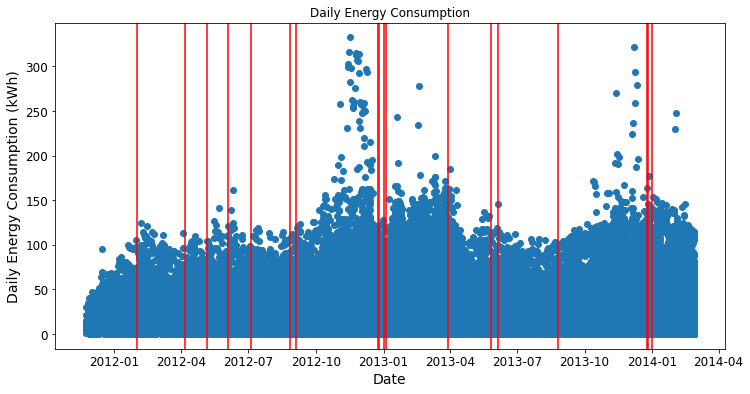

In [62]:
plt.figure(figsize=(12,6))
plt.scatter(energy_daily["time"], energy_daily["energy_sum"], label="Energy Consumption (kWh)")
plt.xlabel("Date")
plt.ylabel("Daily Energy Consumption (kWh)")
plt.title("Daily Energy Consumption")

for h in holiday_daily_list:
    plt.axvline(x=h, color='red')

# red vertical lines indicate holiday
plt.show()

In [63]:
combined_daily_df.select(avg(col("energy_sum"))).show()

+------------------+
|   avg(energy_sum)|
+------------------+
|10.196621989162944|
+------------------+



#### Energy Consumption during Holidays

- Determine if there is a substantial increase in daily energy consumption during holidays.

In [64]:
combined_daily_df.groupBy("holiday_binary").avg("energy_sum").show()

+--------------+------------------+
|holiday_binary|   avg(energy_sum)|
+--------------+------------------+
|             0|10.193354887379332|
|             1|10.344535523929787|
+--------------+------------------+



#### Energy Consumption by Month

In [65]:
energy_month = combined_daily_df.groupBy("month").avg("energy_sum").orderBy(col("month").cast(IntegerType()))
energy_month.show()

energy_month_pd = energy_month.toPandas()

+-----+------------------+
|month|   avg(energy_sum)|
+-----+------------------+
|    1|12.225895523498771|
|    2|11.979783815832832|
|    3|11.980184900553276|
|    4|10.177194527437317|
|    5|  8.93750052716588|
|    6| 8.485935665211828|
|    7| 8.193056358522034|
|    8| 8.020269908585043|
|    9| 8.810358599990609|
|   10| 9.829997531978144|
|   11|11.312896468686013|
|   12|12.173938351206736|
+-----+------------------+



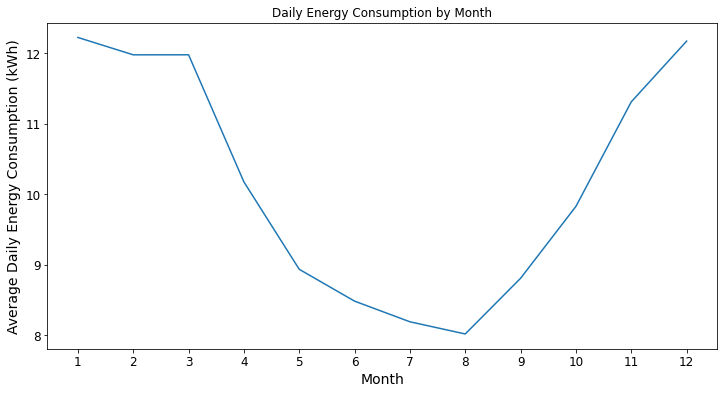

In [66]:
plt.figure(figsize=(12,6))
plt.plot(energy_month_pd["month"], energy_month_pd["avg(energy_sum)"], label="Energy Consumption (kWh)")
plt.xlabel("Month")
plt.ylabel("Average Daily Energy Consumption (kWh)")
plt.title("Daily Energy Consumption by Month")

plt.show()

#### Energy Consumption by Day of Week

In [67]:
energy_dow = combined_daily_df.groupBy("day").avg("energy_sum").orderBy(col("day").cast(IntegerType()))
energy_dow.show()

energy_dow_pd = energy_dow.toPandas()

+---+------------------+
|day|   avg(energy_sum)|
+---+------------------+
|  1|10.776740811938925|
|  2|10.179250341211555|
|  3|10.047049729786858|
|  4|10.022680493741891|
|  5|10.009295087731221|
|  6|10.048399460159164|
|  7|10.299171786383443|
+---+------------------+



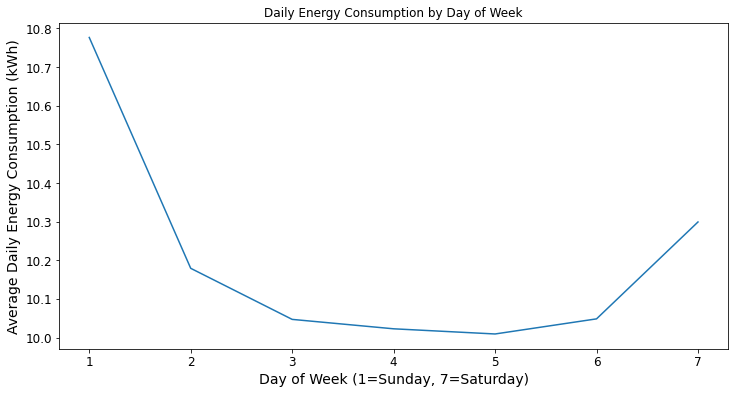

In [68]:
plt.figure(figsize=(12,6))
plt.plot(energy_dow_pd["day"], energy_dow_pd["avg(energy_sum)"], label="Energy Consumption (kWh)")
plt.xlabel("Day of Week (1=Sunday, 7=Saturday)")
plt.ylabel("Average Daily Energy Consumption (kWh)")
plt.title("Daily Energy Consumption by Day of Week")

plt.show()

#### Hourly Energy Consumption for Single Meter 

In [69]:
# count how many observations have no consumption

combined_hourly_df.select(count(when(col("energy") < 0, 1)).alias("Energy Cons. < 0")).show()
combined_hourly_df.select(count(when(col("energy") == 0, 1)).alias("Energy Cons. == 0")).show()
combined_hourly_df.select(count(when(col("energy") > 0, 1)).alias("Energy Cons. > 0")).show()

+----------------+
|Energy Cons. < 0|
+----------------+
|               0|
+----------------+

+-----------------+
|Energy Cons. == 0|
+-----------------+
|                0|
+-----------------+

+----------------+
|Energy Cons. > 0|
+----------------+
|           12106|
+----------------+



In [70]:
# remove data points with no hourly energy consumption as it could suggest power outage or meter misreading

combined_hourly_df = combined_hourly_df.filter(combined_hourly_df.energy > 0)

# check to make sure that there are no remaining data points with 0 daily energy consumption.
combined_hourly_df.select(count(when(col("energy") == 0, 1)).alias("Energy Cons. == 0")).show()

+-----------------+
|Energy Cons. == 0|
+-----------------+
|                0|
+-----------------+



In [71]:
meter_hourly= combined_hourly_df.select("time").collect()
energy_hourly = combined_hourly_df.select("energy").collect()

In [72]:
holiday_hourly_list = combined_hourly_df.select("time").filter(col("holiday_binary") == 1).collect()

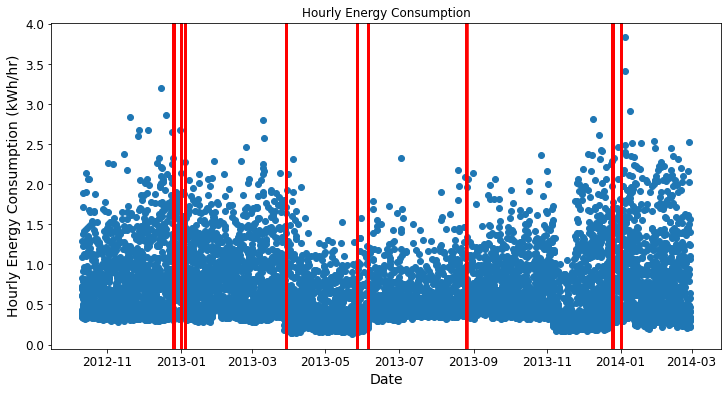

In [73]:
plt.figure(figsize=(12,6))
plt.scatter(meter_hourly, energy_hourly, label="Energy Consumption (kWh/hr)")
plt.xlabel("Date")
plt.ylabel("Hourly Energy Consumption (kWh/hr)")
plt.title("Hourly Energy Consumption")

for h in holiday_hourly_list:
    plt.axvline(x=h, color='red')

plt.show()

In [74]:
combined_hourly_df.select(avg(col("energy"))).show()

+-----------------+
|      avg(energy)|
+-----------------+
|0.600751693049246|
+-----------------+



In [75]:
combined_hourly_df.groupBy("holiday_binary").avg("energy").show()

+--------------+------------------+
|holiday_binary|       avg(energy)|
+--------------+------------------+
|             0|0.5987377973426599|
|             1|0.6910871209181619|
+--------------+------------------+



#### Energy Consumption by Hour

In [76]:
energy_hourly_df = combined_hourly_df.groupby("hour").avg("energy").orderBy(col("hour").cast(IntegerType()))
energy_hourly_df.show(24)

energy_hourly_pd = energy_hourly_df.toPandas()

+----+-------------------+
|hour|        avg(energy)|
+----+-------------------+
|   0| 0.3586011915689423|
|   1| 0.3538015866208644|
|   2|0.34993240494969824|
|   3|0.34890927018733653|
|   4|0.34779761926758856|
|   5| 0.3437936505273221|
|   6|0.35178571345195886|
|   7| 0.3861031738065538|
|   8| 0.4602902591465482|
|   9| 0.5293293652967328|
|  10| 0.5233373011625002|
|  11| 0.5770556659809875|
|  12| 0.6160912700293083|
|  13| 0.6029207914772601|
|  14|  0.606229701785758|
|  15| 0.6047207915251798|
|  16| 0.6750613863810454|
|  17|  0.883037620045171|
|  18|  1.061613861611574|
|  19| 1.0678851475219915|
|  20| 1.0538198010756237|
|  21|   1.06271881402129|
|  22| 0.7815366318910428|
|  23| 0.4675972227834993|
+----+-------------------+



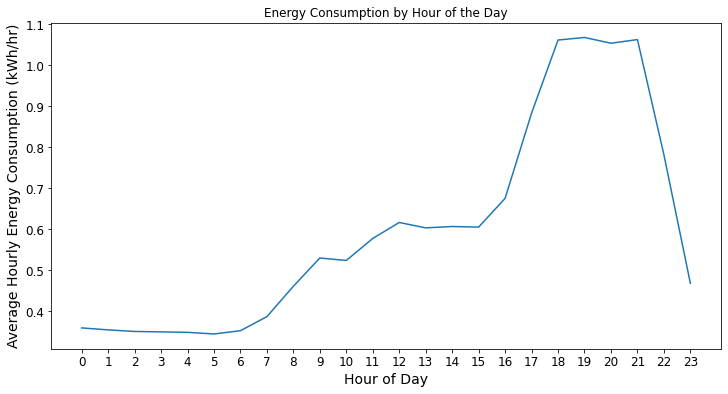

In [77]:
plt.figure(figsize=(12,6))
plt.plot(energy_hourly_pd["hour"], energy_hourly_pd["avg(energy)"], label="Energy Consumption (kWh/hr)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Hourly Energy Consumption (kWh/hr)")
plt.title("Energy Consumption by Hour of the Day")

plt.show()

### ACRON / Socialeconomic Groups

In [78]:
acorn_socialeco_daily = combined_daily_df.select("time", "energy_sum", "Acorn","Socialeconomic").toPandas()

In [79]:
acorn_socialeco_daily

,time,energy_sum,Acorn,Socialeconomic
0,2011-12-08,3.662,ACORN-E,Affluent
1,2011-12-09,6.036,ACORN-E,Affluent
2,2011-12-10,10.063,ACORN-E,Affluent
3,2011-12-11,11.769,ACORN-E,Affluent
4,2011-12-12,5.913,ACORN-E,Affluent
...,...,...,...,...
3474959,2014-02-23,0.683,ACORN-U,ACORN-U
3474960,2014-02-24,2.587,ACORN-U,ACORN-U
3474961,2014-02-25,0.720,ACORN-U,ACORN-U
3474962,2014-02-26,1.051,ACORN-U,ACORN-U


In [80]:
acorn_affluent = acorn_socialeco_daily.loc[acorn_socialeco_daily['Acorn'].isin(['ACORN-A', 'ACORN-B', 'ACORN-C'])]
acorn_rising = acorn_socialeco_daily.loc[acorn_socialeco_daily['Acorn'].isin(['ACORN-D', 'ACORN-E'])]
acorn_comfortable = acorn_socialeco_daily.loc[acorn_socialeco_daily['Acorn'].isin(['ACORN-F', 'ACORN-G', 'ACORN-H', 'ACORN-I', 'ACORN-J'])]
acorn_stretched = acorn_socialeco_daily.loc[acorn_socialeco_daily['Acorn'].isin(['ACORN-K', 'ACORN-L', 'ACORN-M', 'ACORN-N'])]
acorn_adversity = acorn_socialeco_daily.loc[acorn_socialeco_daily['Acorn'].isin(['ACORN-O', 'ACORN-P', 'ACORN-Q'])]
acorn_unknown = acorn_socialeco_daily.loc[acorn_socialeco_daily['Acorn'].isin(['ACORN-U', 'ACORN-'])]

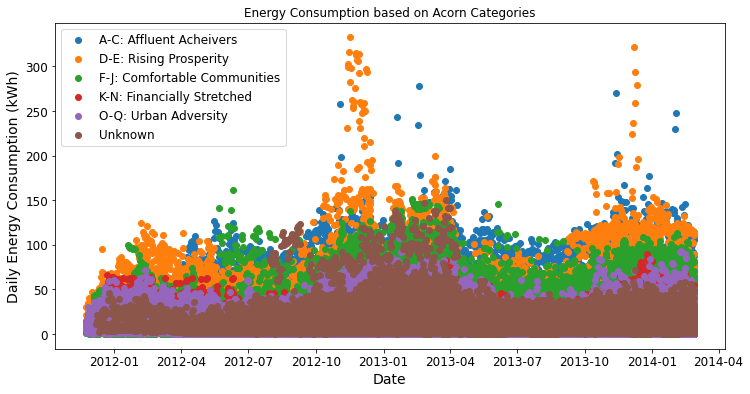

In [81]:
plt.figure(figsize=(12,6))

plt.scatter(acorn_affluent["time"], acorn_affluent["energy_sum"], label="A-C: Affluent Acheivers")
plt.scatter(acorn_rising["time"], acorn_rising["energy_sum"], label="D-E: Rising Prosperity")
plt.scatter(acorn_comfortable["time"], acorn_comfortable["energy_sum"], label="F-J: Comfortable Communities")
plt.scatter(acorn_stretched["time"], acorn_stretched["energy_sum"], label="K-N: Financially Stretched")
plt.scatter(acorn_adversity["time"], acorn_adversity["energy_sum"], label="O-Q: Urban Adversity")
plt.scatter(acorn_unknown["time"], acorn_unknown["energy_sum"], label="Unknown")

plt.xlabel("Date")
plt.ylabel("Daily Energy Consumption (kWh)")
plt.title("Energy Consumption based on Acorn Categories")
plt.legend()

plt.show()

In [82]:
# aggregating by Acron group and calculating the mean energy_sum per Acorn group

energy_acorn_df = combined_daily_df.groupBy("Acorn").avg("energy_sum").orderBy(col("Acorn"))
energy_acorn_df.show()

energy_acorn_pd = energy_acorn_df.toPandas() 

+-------+------------------+
|  Acorn|   avg(energy_sum)|
+-------+------------------+
| ACORN-|12.048254858784349|
|ACORN-A| 19.12800664280064|
|ACORN-B|11.929023443060226|
|ACORN-C|11.981566223237698|
|ACORN-D|13.657404168518239|
|ACORN-E| 10.43611951338815|
|ACORN-F|  9.26099702755155|
|ACORN-G|10.230697020405724|
|ACORN-H|11.053586421679396|
|ACORN-I| 9.463164078754605|
|ACORN-J|11.412777221304937|
|ACORN-K| 10.09884034965985|
|ACORN-L|10.061373440438292|
|ACORN-M|10.026656021463499|
|ACORN-N| 9.261338167340641|
|ACORN-O| 8.579916733043238|
|ACORN-P| 6.700596644436196|
|ACORN-Q| 7.627956975151605|
|ACORN-U| 12.20224336225712|
+-------+------------------+



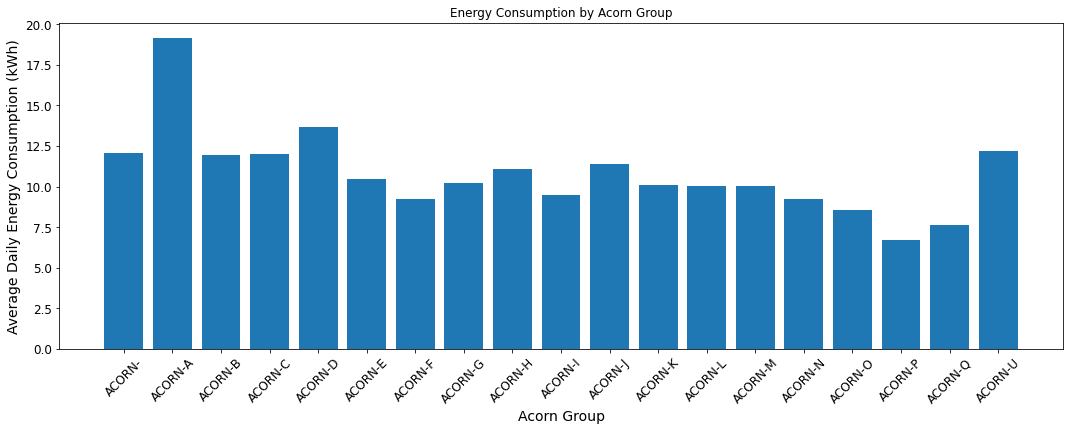

In [83]:
plt.figure(figsize=(18,6))
plt.bar(energy_acorn_pd["Acorn"], energy_acorn_pd["avg(energy_sum)"])
plt.xlabel("Acorn Group")
plt.xticks(rotation=45) 
plt.ylabel("Average Daily Energy Consumption (kWh)")

plt.title("Energy Consumption by Acorn Group")

plt.show()

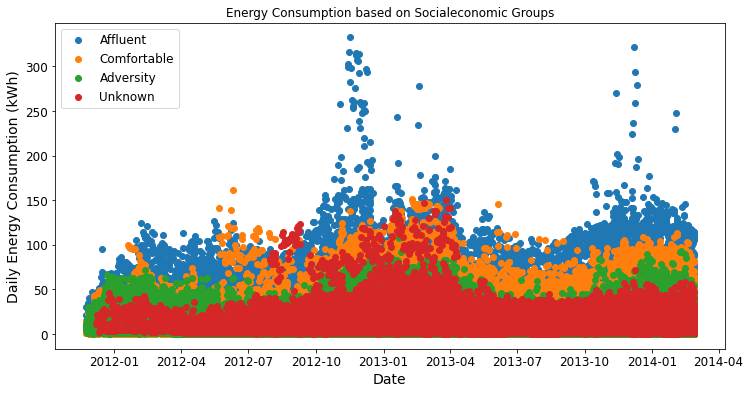

In [84]:
plt.figure(figsize=(12,6))

socialeco_affluent = acorn_socialeco_daily.loc[acorn_socialeco_daily['Socialeconomic'] == "Affluent"]
socialeco_comfortable = acorn_socialeco_daily.loc[acorn_socialeco_daily['Socialeconomic'] == "Comfortable"]
socialeco_adversity = acorn_socialeco_daily.loc[acorn_socialeco_daily['Socialeconomic'] == "Adversity"]
socialeco_unknown = acorn_socialeco_daily.loc[acorn_socialeco_daily['Socialeconomic'].isin(["ACORN-U","ACORN-"])]

plt.scatter(socialeco_affluent["time"], socialeco_affluent["energy_sum"], label="Affluent")
plt.scatter(socialeco_comfortable["time"], socialeco_comfortable["energy_sum"], label="Comfortable")
plt.scatter(socialeco_adversity["time"], socialeco_adversity["energy_sum"], label="Adversity")
plt.scatter(socialeco_unknown["time"], socialeco_unknown["energy_sum"], label="Unknown")

plt.xlabel("Date")
plt.ylabel("Daily Energy Consumption (kWh)")
plt.title("Energy Consumption based on Socialeconomic Groups")
plt.legend()
plt.show()

In [85]:
energy_socialeco_df = combined_daily_df.groupBy("Socialeconomic").avg("energy_sum").orderBy(col("avg(energy_sum)").desc())
energy_socialeco_df.show()

+--------------+------------------+
|Socialeconomic|   avg(energy_sum)|
+--------------+------------------+
|       ACORN-U| 12.20224336225712|
|        ACORN-|12.048254858784349|
|      Affluent|11.558844058868964|
|   Comfortable|10.065252870330317|
|     Adversity| 8.563998979374434|
+--------------+------------------+



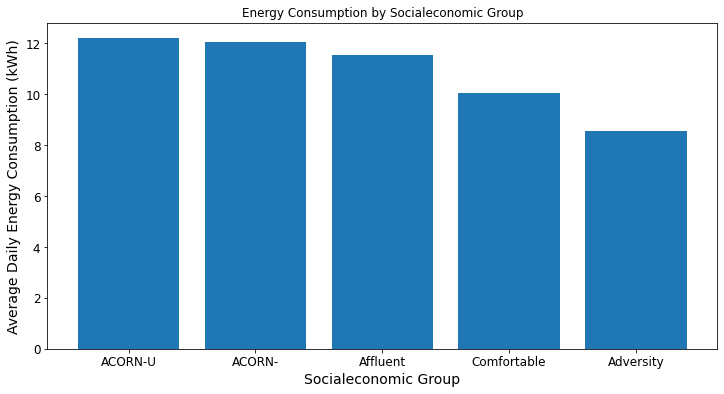

In [86]:
energy_socialeco_pd = energy_socialeco_df.toPandas()

plt.figure(figsize=(12,6))
plt.bar(energy_socialeco_pd["Socialeconomic"], energy_socialeco_pd["avg(energy_sum)"])
plt.xlabel("Socialeconomic Group")
plt.ylabel("Average Daily Energy Consumption (kWh)")

plt.title("Energy Consumption by Socialeconomic Group")

plt.show()

#### Energy Consumption by Billing Method

In [87]:
billing_daily = combined_daily_df.select("time", "energy_sum", "stdorToU").toPandas()
billing_daily

,time,energy_sum,stdorToU
0,2011-12-08,3.662,ToU
1,2011-12-09,6.036,ToU
2,2011-12-10,10.063,ToU
3,2011-12-11,11.769,ToU
4,2011-12-12,5.913,ToU
...,...,...,...
3474959,2014-02-23,0.683,Std
3474960,2014-02-24,2.587,Std
3474961,2014-02-25,0.720,Std
3474962,2014-02-26,1.051,Std


In [88]:
billing_standard = billing_daily.loc[billing_daily['stdorToU'].isin(['Std'])]
billing_ToU = billing_daily.loc[billing_daily['stdorToU'].isin(['ToU'])]

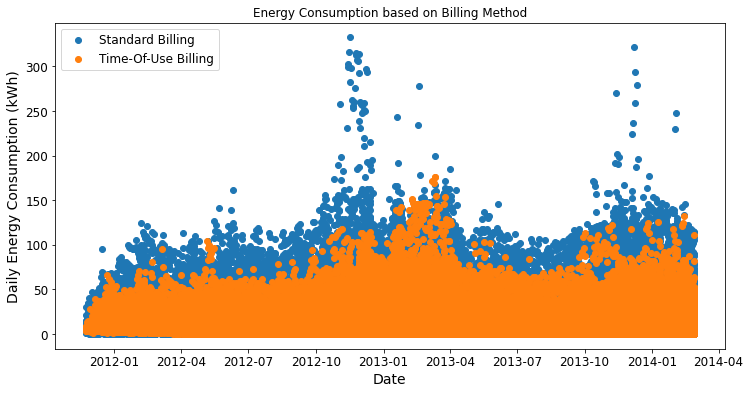

In [89]:
plt.figure(figsize=(12,6))

plt.scatter(billing_standard["time"], billing_standard["energy_sum"], label="Standard Billing")
plt.scatter(billing_ToU["time"], billing_ToU["energy_sum"], label="Time-Of-Use Billing")

plt.xlabel("Date")
plt.ylabel("Daily Energy Consumption (kWh)")
plt.title("Energy Consumption based on Billing Method")
plt.legend()

plt.show()

In [90]:
combined_daily_df.groupBy("stdorToU").avg("energy_sum").show()

+--------+------------------+
|stdorToU|   avg(energy_sum)|
+--------+------------------+
|     Std|10.360841009694253|
|     ToU| 9.545980184543152|
+--------+------------------+



### Weather 

#### Daily Weather 

In [91]:
daily_time = combined_daily_df.select("time").collect()

In [92]:
daily_energy_sum = combined_daily_df.select("energy_sum").collect()
daily_temp_High = combined_daily_df.select("tempHigh").collect()
daily_temp_Low = combined_daily_df.select("tempLow").collect()

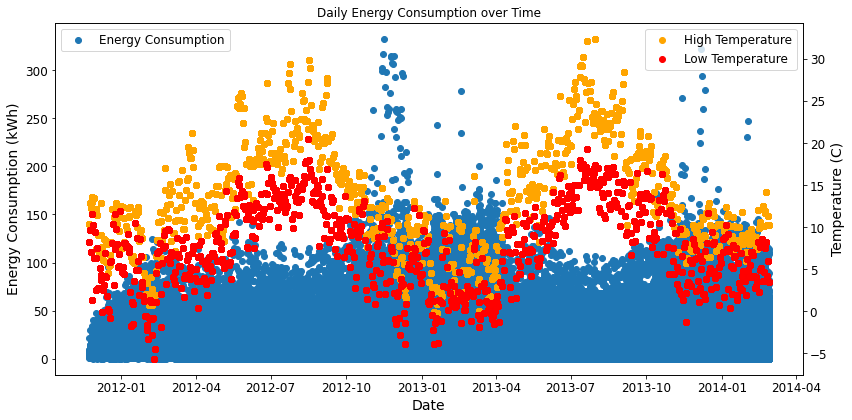

In [93]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.scatter(daily_time, daily_energy_sum, label="Energy Consumption")
ax1.set_xlabel("Date")
ax1.set_ylabel("Energy Consumption (kWh)")

ax2 = ax1.twinx() 
ax2.scatter(daily_time, daily_temp_High, color='orange', label="High Temperature")
ax2.scatter(daily_time, daily_temp_Low, color='red', label="Low Temperature")
ax2.set_ylabel("Temperature (C)")

plt.title("Daily Energy Consumption over Time")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
fig.tight_layout()
plt.show()

In [94]:
# correlation between Daily High Temperature and Energy Consumption:

combined_daily_df.stat.corr('energy_sum','tempHigh')

-0.1732051877631666

#### Energy Consumption by Weather Outlook

In [95]:
energy_icon_df = combined_daily_df.groupBy("icon").avg("energy_sum").orderBy(col("icon"))
energy_icon_df.show()

+-------------------+------------------+
|               icon|   avg(energy_sum)|
+-------------------+------------------+
|          clear-day| 9.608332991260264|
|             cloudy|10.661536624241617|
|                fog|11.144131894964474|
|  partly-cloudy-day|  9.93359312604149|
|partly-cloudy-night|11.939521135913347|
|               wind|10.647832970154838|
+-------------------+------------------+



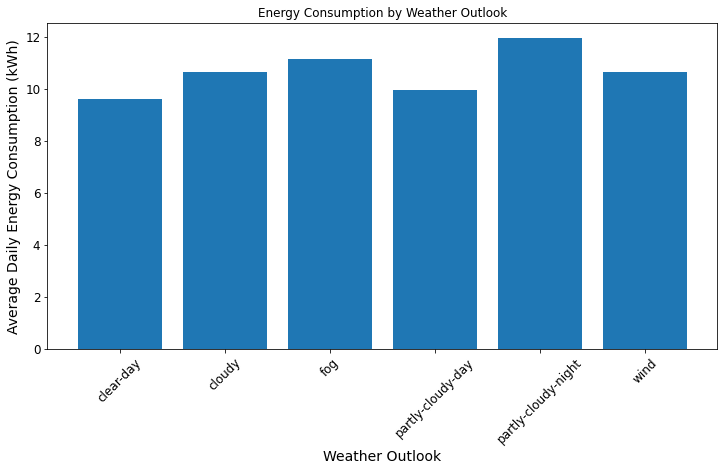

In [96]:
energy_icon_pd = energy_icon_df.toPandas()

plt.figure(figsize=(12,6))
plt.bar(energy_icon_pd["icon"], energy_icon_pd["avg(energy_sum)"])
plt.xlabel("Weather Outlook")
plt.ylabel("Average Daily Energy Consumption (kWh)")
plt.xticks(rotation=45) 
plt.title("Energy Consumption by Weather Outlook")

plt.show()

#### Energy Consumption by Wind Speed

In [97]:
daily_windSpd = combined_daily_df.select("windSpd").collect()

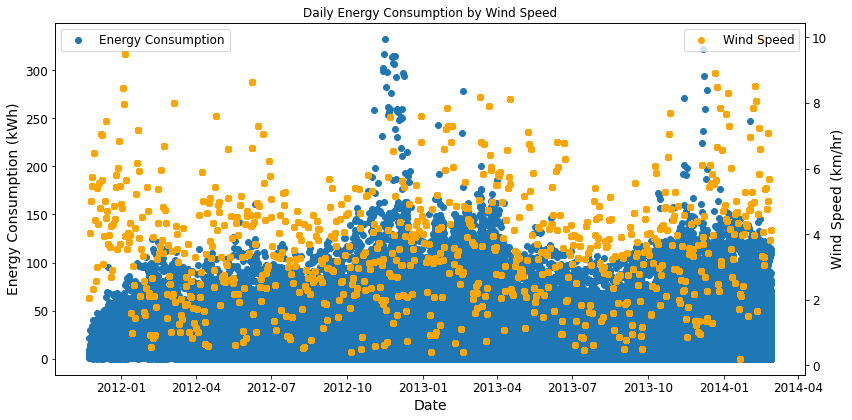

In [98]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.scatter(daily_time, daily_energy_sum, label="Energy Consumption")
ax1.set_xlabel("Date")
ax1.set_ylabel("Energy Consumption (kWh)")

ax2 = ax1.twinx() 
ax2.scatter(daily_time, daily_windSpd, color='orange', label="Wind Speed")
ax2.set_ylabel("Wind Speed (km/hr)")

plt.title("Daily Energy Consumption by Wind Speed")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
fig.tight_layout()
plt.show()

In [99]:
# correlation between Daily Energy Consumption and Wind Speed:

combined_daily_df.stat.corr('energy_sum','WindSpd')

0.03402477922759102

#### Energy Consumption by UV Index

In [100]:
energy_uv_df = combined_daily_df.groupBy("uv").avg("energy_sum").orderBy(col("uv"))
energy_uv_df.show()

+---+------------------+
| uv|   avg(energy_sum)|
+---+------------------+
|0.0| 11.90211761609107|
|1.0|11.605169262305026|
|2.0|10.289125969888508|
|3.0| 9.593432321132601|
|4.0|  8.71420807406983|
|5.0| 8.523422494328603|
|6.0| 8.386132952310797|
|7.0| 8.120977163093405|
+---+------------------+



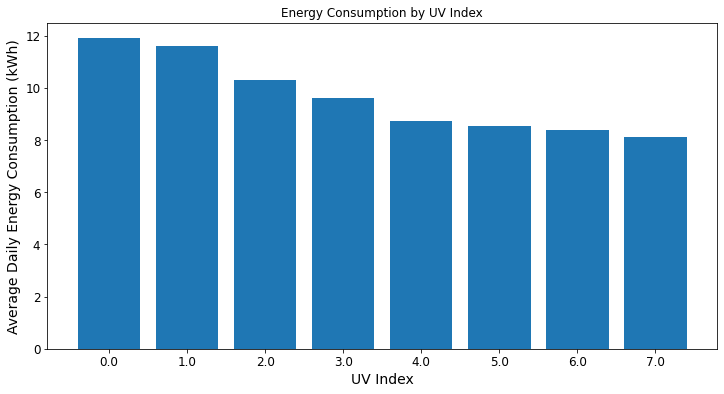

In [101]:
energy_uv_pd = energy_uv_df.toPandas()

plt.figure(figsize=(12,6))
plt.bar(energy_uv_pd["uv"], energy_uv_pd["avg(energy_sum)"])
plt.xlabel("UV Index")
plt.ylabel("Average Daily Energy Consumption (kWh)")

plt.title("Energy Consumption by UV Index")

plt.show()

# Regression Models

#### Linear Regression Model with Daily Data

In [102]:
model_daily_df = combined_daily_df.select("energy_sum", "stdorToU", "Acorn", "Socialeconomic", "windDir", "windSpd", "icon", "dew", "cloudCover", "pres", "precip", "vis", "humid", "uv", "tempHigh", "tempLow", "moonPhase", "month", "day", "holiday_binary")

In [103]:
# correlation of numerical features vs. energy_sum
# citing https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-
# mllib-d065c3ba246a for code reference

for i in model_daily_df.columns:
    if i not in "energy_sum":
        if not( isinstance(model_daily_df.select(i).take(1)[0][0], str)):
            print( "Correlation to energy_sum for", i, round(model_daily_df.stat.corr('energy_sum',i),2))

Correlation to energy_sum for windDir -0.02
Correlation to energy_sum for windSpd 0.03
Correlation to energy_sum for dew -0.15
Correlation to energy_sum for cloudCover 0.06
Correlation to energy_sum for pres -0.04
Correlation to energy_sum for vis -0.06
Correlation to energy_sum for humid 0.08
Correlation to energy_sum for tempHigh -0.17
Correlation to energy_sum for tempLow -0.16
Correlation to energy_sum for moonPhase -0.01


In [104]:
model_daily_df.show()

+----------+--------+-------+--------------+-------+-------+-------------------+-----+----------+-------+------+-----+-----+---+--------+-------+---------+-----+---+--------------+
|energy_sum|stdorToU|  Acorn|Socialeconomic|windDir|windSpd|               icon|  dew|cloudCover|   pres|precip|  vis|humid| uv|tempHigh|tempLow|moonPhase|month|day|holiday_binary|
+----------+--------+-------+--------------+-------+-------+-------------------+-----+----------+-------+------+-----+-----+---+--------+-------+---------+-----+---+--------------+
|     3.662|     ToU|ACORN-E|      Affluent|    234|   7.01|               wind| 5.96|      0.53|1010.84|  rain|12.59| 0.81|1.0|   12.89|   3.76|     0.43|   12|  5|             0|
|     6.036|     ToU|ACORN-E|      Affluent|    255|   5.65|  partly-cloudy-day| 0.41|      0.15| 1010.6|  rain|12.83| 0.71|1.0|    7.68|  -0.13|     0.46|   12|  6|             0|
|    10.063|     ToU|ACORN-E|      Affluent|    247|   3.08|  partly-cloudy-day|-0.34|      0.1

In [105]:
# prepare data

supervised_daily = RFormula(formula="energy_sum ~.")

fittedRF_daily = supervised_daily.fit(model_daily_df)

In [106]:
# perform 80% train - 20% test split
train_daily, test_daily = model_daily_df.randomSplit([0.8, 0.2], seed=63)

In [107]:
prepared_daily_train_df = fittedRF_daily.transform(train_daily)
prepared_daily_test_df = fittedRF_daily.transform(test_daily)

prepared_daily_train_df.show(5)
prepared_daily_test_df.show(5)

+----------+--------+-------+--------------+-------+-------+-----------------+----+----------+-------+------+-----+-----+---+--------+-------+---------+-----+---+--------------+--------------------+--------------------+
|energy_sum|stdorToU|  Acorn|Socialeconomic|windDir|windSpd|             icon| dew|cloudCover|   pres|precip|  vis|humid| uv|tempHigh|tempLow|moonPhase|month|day|holiday_binary|            features|               label|
+----------+--------+-------+--------------+-------+-------+-----------------+----+----------+-------+------+-----+-----+---+--------+-------+---------+-----+---+--------------+--------------------+--------------------+
|     0.001|     Std|ACORN-E|      Affluent|    157|   2.19|              fog|2.76|      0.37|1010.13|  rain| 6.36| 0.89|1.0|    7.66|   5.76|     0.66|    1|  3|             0|(64,[0,1,19,23,24...|0.001000000047497...|
|     0.001|     Std|ACORN-E|      Affluent|    192|    4.4|             wind|3.88|      0.44|1000.02|  rain|11.67| 0.87

In [108]:
prepared_daily_train_df.select("features").show(5,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(64,[0,1,19,23,24,27,30,31,32,33,34,35,36,43,44,45,47,58,63],[1.0,1.0,1.0,157.0,2.190000057220459,1.0,2.759999990463257,0.3700000047683716,1010.1300048828125,1.0,6.3600

In [109]:
mean_energy_daily=model_daily_df.select(avg(col("energy_sum"))).collect()[0][0]
mean_energy_daily

10.196621989162944

In [110]:
model_daily_df.select("energy_sum").describe().show()

+-------+------------------+
|summary|        energy_sum|
+-------+------------------+
|  count|           3474964|
|   mean|10.196621989162944|
| stddev| 9.120938792278329|
|    min|             0.001|
|    max|           332.556|
+-------+------------------+



In [111]:
# create linear regression model

lr_daily = LinearRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1, elasticNetParam=0.1)

lr_daily_model = lr_daily.fit(prepared_daily_train_df)

# view model coefficients and intercept

print("Coefficients: " + str(np.round(lr_daily_model.coefficients,2)))
print("Intercept: " + str(np.round(lr_daily_model.intercept,2)))

Coefficients: [ 1.07 -0.49 -1.74 -0.86  0.7   0.57  2.68  0.    0.62  7.97 -0.13  0.83
 -2.54  0.4   1.09 -0.81 -0.7   0.93  0.65  0.78 -0.83  0.    0.93 -0.
  0.01  0.    0.   -0.03  0.19 -0.22 -0.1   0.53 -0.   -0.6  -0.03  1.12
  0.54 -0.35 -0.35  0.27 -0.19  0.    0.45 -0.05  0.    0.    0.58  0.4
 -0.01 -0.77 -0.79  0.12 -0.62 -0.99 -0.94 -0.81 -0.27 -0.54 -0.47 -0.34
 -0.23 -0.53 -0.51  0.  ]
Intercept: 13.89


In [112]:
# view index-to-feature mapping to identify which index position corresponds with which feature

coef_daily = lr_daily_model.coefficients

print("Maximum model coefficient:", np.round(max(np.abs(coef_daily)),2))
print("Index position of maximum model coefficient:", np.argmax(coef_daily))

numeric_coeff_daily = prepared_daily_train_df.select("features").schema[0].metadata.get(
    'ml_attr').get('attrs').get('numeric')
categorical_coeff_daily = prepared_daily_train_df.select("features").schema[0].metadata.get(
    'ml_attr').get('attrs').get('binary')

model_coeff_daily = numeric_coeff_daily + categorical_coeff_daily 
model_coeff_daily

Maximum model coefficient: 7.97
Index position of maximum model coefficient: 9


[{'idx': 23, 'name': 'windDir'},
 {'idx': 24, 'name': 'windSpd'},
 {'idx': 30, 'name': 'dew'},
 {'idx': 31, 'name': 'cloudCover'},
 {'idx': 32, 'name': 'pres'},
 {'idx': 34, 'name': 'vis'},
 {'idx': 35, 'name': 'humid'},
 {'idx': 43, 'name': 'tempHigh'},
 {'idx': 44, 'name': 'tempLow'},
 {'idx': 45, 'name': 'moonPhase'},
 {'idx': 0, 'name': 'stdorToU_Std'},
 {'idx': 1, 'name': 'Acorn_ACORN-E'},
 {'idx': 2, 'name': 'Acorn_ACORN-Q'},
 {'idx': 3, 'name': 'Acorn_ACORN-F'},
 {'idx': 4, 'name': 'Acorn_ACORN-H'},
 {'idx': 5, 'name': 'Acorn_ACORN-L'},
 {'idx': 6, 'name': 'Acorn_ACORN-D'},
 {'idx': 7, 'name': 'Acorn_ACORN-G'},
 {'idx': 8, 'name': 'Acorn_ACORN-K'},
 {'idx': 9, 'name': 'Acorn_ACORN-A'},
 {'idx': 10, 'name': 'Acorn_ACORN-N'},
 {'idx': 11, 'name': 'Acorn_ACORN-C'},
 {'idx': 12, 'name': 'Acorn_ACORN-P'},
 {'idx': 13, 'name': 'Acorn_ACORN-M'},
 {'idx': 14, 'name': 'Acorn_ACORN-J'},
 {'idx': 15, 'name': 'Acorn_ACORN-O'},
 {'idx': 16, 'name': 'Acorn_ACORN-I'},
 {'idx': 17, 'name': 'Aco

In [113]:
# view training R2 and RMSE
trainingSummary_daily = lr_daily_model.summary
print("RMSE: %.2f" % trainingSummary_daily.rootMeanSquaredError)
print("r2: %.3f" % trainingSummary_daily.r2)

RMSE: 8.70
r2: 0.090


In [114]:
# view test predictions
lr_daily_predictions = lr_daily_model.transform(prepared_daily_test_df)
lr_daily_predictions_df = lr_daily_predictions.select("prediction","energy_sum").toPandas()

In [115]:
# view test predictions
lr_daily_predictions_df['prediction'].describe()

count    696380.000000
mean         10.198299
std           2.670770
min           2.769965
25%           8.470494
50%           9.906351
75%          11.807068
max          23.414399
Name: prediction, dtype: float64

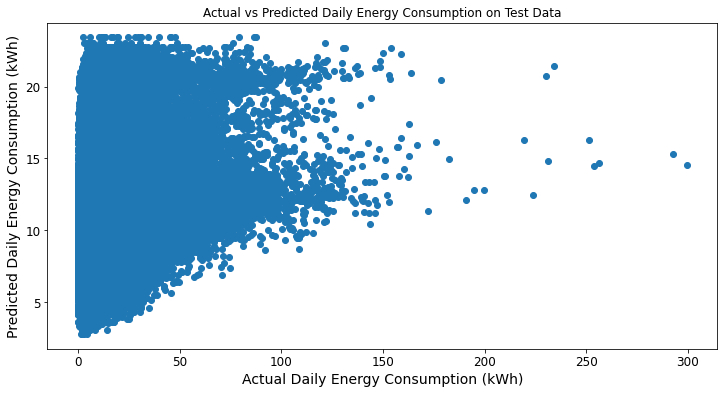

In [116]:
# view test predictions as compared to actual energy consumption data 
plt.figure(figsize=(12,6))
plt.scatter(lr_daily_predictions_df['energy_sum'],lr_daily_predictions_df['prediction'])
plt.xlabel("Actual Daily Energy Consumption (kWh)")
plt.ylabel("Predicted Daily Energy Consumption (kWh)")
plt.title("Actual vs Predicted Daily Energy Consumption on Test Data")
plt.show()

In [117]:
# view test R2
lr_daily_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="energy_sum",
                                        metricName="r2")
lr_daily_test_r2 = lr_daily_evaluator.evaluate(lr_daily_predictions)
print("R Squared (R2) on test data = %.2g" % lr_daily_test_r2)

R Squared (R2) on test data = 0.089


In [118]:
# view test RMSE
lr_daily_test_result = lr_daily_model.evaluate(prepared_daily_test_df)
print("Root Mean Squared Error (RMSE) on test data = %.3g" % 
      lr_daily_test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 8.71


### Decision Tree

In [119]:
# build decision tree model and fit on the training dataset used for linear regression
daily_dt = DecisionTreeRegressor(featuresCol='features')
daily_dt_model = daily_dt.fit(prepared_daily_train_df)

In [120]:
# making predictions on test dataset

daily_dt_predictions = daily_dt_model.transform(prepared_daily_test_df)
daily_dt_predictions.select("prediction", "label", "features").show(5)

+-----------------+--------------------+--------------------+
|       prediction|               label|            features|
+-----------------+--------------------+--------------------+
|12.40950142386265|0.001000000047497...|(64,[0,1,19,23,24...|
| 8.34941033777542|0.001000000047497...|(64,[0,1,19,23,24...|
|12.40950142386265|0.001000000047497...|(64,[0,1,19,23,24...|
|12.40950142386265|0.001000000047497...|(64,[0,1,19,23,24...|
|12.40950142386265|0.001000000047497...|(64,[0,1,19,23,24...|
+-----------------+--------------------+--------------------+
only showing top 5 rows



In [121]:
# Show decision tree performance

# Select (prediction, true label) and compute test error
daily_dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
daily_dt_rmse = daily_dt_evaluator.evaluate(daily_dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %.3g" % daily_dt_rmse)


Root Mean Squared Error (RMSE) on test data = 8.75


In [122]:
# View decision tree feature importance
# Check with linear regression index-to-feature mapping to identify features with highest magnitude.
daily_dt_model.featureImportances

SparseVector(64, {0: 0.0128, 2: 0.0581, 3: 0.026, 6: 0.0936, 9: 0.3243, 12: 0.0141, 20: 0.1163, 36: 0.001, 37: 0.0006, 43: 0.3519, 46: 0.0003, 50: 0.0002, 55: 0.0008, 58: 0.0001})

#### Random Forest Regression

In [123]:
# build random forest model and fit on the training dataset used for linear regression
daily_rf = RandomForestRegressor(featuresCol="features")
daily_rf_model = daily_rf.fit(prepared_daily_train_df)

In [124]:
# making predictions on test dataset
daily_rf_predictions = daily_rf_model.transform(prepared_daily_test_df)
daily_rf_predictions.select("prediction", "label", "features").show(5)

+------------------+--------------------+--------------------+
|        prediction|               label|            features|
+------------------+--------------------+--------------------+
|12.008921380790559|0.001000000047497...|(64,[0,1,19,23,24...|
| 9.508962607370705|0.001000000047497...|(64,[0,1,19,23,24...|
|11.406650471195688|0.001000000047497...|(64,[0,1,19,23,24...|
|12.597117715891931|0.001000000047497...|(64,[0,1,19,23,24...|
|12.465459005182565|0.001000000047497...|(64,[0,1,19,23,24...|
+------------------+--------------------+--------------------+
only showing top 5 rows



In [125]:
# Show random forest tree performance

# Select (prediction, true label) and compute test error
daily_rf_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
daily_rf_rmse = daily_rf_evaluator.evaluate(daily_rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %.3g" % daily_rf_rmse)

Root Mean Squared Error (RMSE) on test data = 8.74


In [126]:
# View random forest feature importance.  
# Check with linear regression index-to-feature mapping to identify features with highest magnitude.
daily_rf_model.featureImportances

SparseVector(64, {0: 0.0081, 1: 0.024, 2: 0.0702, 3: 0.0118, 4: 0.0019, 5: 0.0052, 6: 0.0418, 8: 0.0016, 9: 0.2922, 11: 0.0003, 12: 0.004, 13: 0.0002, 14: 0.0009, 15: 0.0001, 17: 0.0007, 19: 0.0399, 20: 0.0975, 21: 0.0063, 23: 0.0001, 24: 0.0001, 25: 0.0, 27: 0.0, 28: 0.0, 30: 0.0697, 31: 0.0003, 32: 0.0001, 33: 0.0001, 34: 0.0001, 35: 0.002, 36: 0.0322, 37: 0.0015, 38: 0.0004, 39: 0.0003, 41: 0.0, 42: 0.0023, 43: 0.1981, 44: 0.076, 45: 0.0001, 46: 0.0004, 47: 0.0039, 48: 0.0001, 49: 0.0029, 50: 0.0005, 51: 0.0, 52: 0.0, 55: 0.0019, 56: 0.0002, 57: 0.0, 58: 0.0, 60: 0.0, 61: 0.0})

### Gradient Boosted Tree Regression

In [127]:
# build gradient boosted tree model and fit on the training dataset used for linear regression
daily_gbt = GBTRegressor(featuresCol="features")
daily_gbt_model = daily_gbt.fit(prepared_daily_train_df)

In [128]:
# making predictions on test dataset

daily_gbt_predictions = daily_gbt_model.transform(prepared_daily_test_df)
daily_gbt_predictions.select("prediction", "label", "features").show(5)

+------------------+--------------------+--------------------+
|        prediction|               label|            features|
+------------------+--------------------+--------------------+
| 12.50148310760473|0.001000000047497...|(64,[0,1,19,23,24...|
| 8.969642023420574|0.001000000047497...|(64,[0,1,19,23,24...|
|12.538030715974894|0.001000000047497...|(64,[0,1,19,23,24...|
|12.333155367930322|0.001000000047497...|(64,[0,1,19,23,24...|
|12.820850462739088|0.001000000047497...|(64,[0,1,19,23,24...|
+------------------+--------------------+--------------------+
only showing top 5 rows



In [129]:
# Show gradient tree performance

# Select (prediction, true label) and compute test error
daily_gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
daily_gbt_rmse = daily_gbt_evaluator.evaluate(daily_gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %.3g" % daily_gbt_rmse)

Root Mean Squared Error (RMSE) on test data = 8.69


In [130]:
# View gradient boosted tree feature importance.  
# Check with linear regression index-to-feature mapping to identify features with highest magnitude.
daily_gbt_model.featureImportances

SparseVector(64, {0: 0.0979, 1: 0.0108, 2: 0.0255, 3: 0.019, 4: 0.0172, 5: 0.0001, 6: 0.0353, 7: 0.0033, 8: 0.0025, 9: 0.1193, 10: 0.0067, 11: 0.0315, 12: 0.0568, 13: 0.002, 14: 0.0171, 15: 0.0183, 16: 0.0052, 17: 0.0168, 18: 0.0092, 19: 0.0003, 20: 0.0554, 23: 0.0066, 24: 0.0031, 25: 0.0004, 28: 0.0, 29: 0.0, 30: 0.0106, 31: 0.0037, 32: 0.0069, 33: 0.0002, 34: 0.0041, 35: 0.0038, 36: 0.0227, 37: 0.02, 38: 0.0076, 39: 0.0022, 40: 0.0002, 41: 0.0006, 42: 0.0034, 43: 0.294, 44: 0.0025, 45: 0.0025, 46: 0.0159, 47: 0.0024, 48: 0.0002, 49: 0.0121, 50: 0.0011, 51: 0.0006, 52: 0.0001, 53: 0.0003, 54: 0.0, 55: 0.0067, 56: 0.0035, 57: 0.0018, 58: 0.0029, 59: 0.0014, 60: 0.0003, 61: 0.0023, 62: 0.0027, 63: 0.0002})

## Regression for Single Meter Hourly Dataset

In [131]:
model_hourly_df = combined_hourly_df.select("energy", "windDir", "windSpd", "icon", "dew", "vis","precip", "humid", "temp", "month", "day", "hour", "holiday_binary")

In [132]:
model_hourly_df.show()

+------+-------+-------+-------------------+----+-----+------+-----+-----+-----+---+----+--------------+
|energy|windDir|windSpd|               icon| dew|  vis|precip|humid| temp|month|day|hour|holiday_binary|
+------+-------+-------+-------------------+----+-----+------+-----+-----+-----+---+----+--------------+
| 0.436|    102|   2.67|  partly-cloudy-day|6.03|13.52|  rain| 0.58|14.13|   10|  4|  13|             0|
| 0.609|    108|   2.63|  partly-cloudy-day|6.72|13.52|  rain| 0.61|14.12|   10|  4|  14|             0|
| 0.724|    105|   2.89|  partly-cloudy-day|7.43|13.07|  rain| 0.66|13.63|   10|  4|  15|             0|
| 0.828|    108|   3.39|  partly-cloudy-day|7.05|13.47|  rain| 0.65|13.47|   10|  4|  16|             0|
| 1.295|    116|   2.91|  partly-cloudy-day|6.63|13.44|  rain| 0.66|12.76|   10|  4|  17|             0|
| 0.728|    125|   2.74|partly-cloudy-night|6.16|13.34|  rain| 0.67|12.13|   10|  4|  18|             0|
| 0.695|    117|   2.45|partly-cloudy-night|6.05|12.76|

In [133]:
mean_energy_hourly=model_hourly_df.select(avg(col("energy"))).collect()[0][0]
mean_energy_hourly

0.600751693049246

In [134]:
model_hourly_df.select("energy").describe().show()

+-------+-------------------+
|summary|             energy|
+-------+-------------------+
|  count|              12106|
|   mean|  0.600751693049246|
| stddev|0.39240966375465336|
|    min|              0.132|
|    max|              3.831|
+-------+-------------------+



In [135]:
# correlation of numerical features vs. energy_sum
# citing https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-
# mllib-d065c3ba246a for code reference

for i in model_hourly_df.columns:
    if i not in "energy":
        if not( isinstance(model_hourly_df.select(i).take(1)[0][0], str)):
            print( "Correlation to energy for", i, round(model_hourly_df.stat.corr('energy',i),2))

Correlation to energy for windDir -0.0
Correlation to energy for windSpd 0.12
Correlation to energy for dew -0.05
Correlation to energy for vis 0.03
Correlation to energy for humid 0.0
Correlation to energy for temp -0.05


In [136]:
# prepare data

supervised_hourly = RFormula(formula="energy ~ .")

fittedRF_hourly = supervised_hourly.fit(model_hourly_df)

In [137]:
# perform 80% train - 20% test split
train_hourly, test_hourly = model_hourly_df.randomSplit([0.8, 0.2], seed=63)

In [138]:
prepared_hourly_train_df = fittedRF_hourly.transform(train_hourly)
prepared_hourly_test_df = fittedRF_hourly.transform(test_hourly)

prepared_hourly_train_df.show(5)
prepared_hourly_test_df.show(5)

+------+-------+-------+-----------------+-----+-----+------+-----+-----+-----+---+----+--------------+--------------------+-------------------+
|energy|windDir|windSpd|             icon|  dew|  vis|precip|humid| temp|month|day|hour|holiday_binary|            features|              label|
+------+-------+-------+-----------------+-----+-----+------+-----+-----+-----+---+----+--------------+--------------------+-------------------+
| 0.142|    276|   3.54|      clear-night| 2.73|13.53|  rain| 0.78| 6.32|    5|  5|  23|             0|(54,[0,1,3,8,9,10...| 0.1420000046491623|
| 0.147|     23|   4.07|      clear-night|-1.88|13.02|  snow| 0.84|  0.5|    4|  4|   4|             0|(54,[0,1,3,8,9,11...| 0.1469999998807907|
| 0.149|     36|   3.77|      clear-night|-2.86|13.92|  snow| 0.78| 0.48|    4|  3|   4|             0|(54,[0,1,3,8,9,11...|0.14900000393390656|
| 0.152|    153|   1.93|partly-cloudy-day| 4.08|12.26|  rain| 0.52|13.78|    5|  5|  11|             0|(54,[0,1,2,8,9,10...|0.1519

In [139]:
prepared_hourly_train_df.select("features").show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(54,[0,1,3,8,9,10,11,12,19,24,45,53],[276.0,3.5399999618530273,1.0,2.7300000190734863,13.529999732971191,1.0,0.7799999713897705,6.320000171661377,1.0,1.0,1.0,1.0])|
|(54,[0,1,3,8,9,11,12,22,25,46,53],[23.0,4.070000171661377,1.0,-1.8799999952316284,13.020000457763672,0.8399999737739563,0.5,1.0,1.0,1.0,1.0])                      |
|(54,[0,1,3,8,9,11,12,22,28,46,53],[36.0,3.7699999809265137,1.0,-2.859999895095825,13.920000076293945,0.7799999713897705,0.47999998927116394,1.0,1.0,1.0,1.0])      |
|(54

In [140]:
# create linear regression model

lr_hourly = LinearRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1, elasticNetParam=0.1)

lr_hourly_model = lr_hourly.fit(prepared_hourly_train_df)

# view model coefficients and intercept
print("Coefficients: " + str(np.round(lr_hourly_model.coefficients,2)))
print("Intercept: " + str(np.round(lr_hourly_model.intercept,2)))

Coefficients: [ 0.    0.01  0.   -0.02  0.06  0.    0.    0.    0.    0.    0.    0.04
 -0.    0.07  0.08 -0.01  0.02  0.    0.   -0.17 -0.02  0.   -0.12 -0.04
  0.    0.   -0.01  0.    0.    0.   -0.14  0.    0.    0.    0.05  0.21
  0.34  0.35  0.34  0.35  0.13 -0.14 -0.13  0.    0.   -0.04 -0.14 -0.15
 -0.15 -0.12  0.    0.   -0.14  0.  ]
Intercept: 0.5


In [141]:
# view index-to-feature mapping to identify which index position corresponds with which feature

coef_hourly = lr_hourly_model.coefficients

print("Maximum model coefficient:", np.round(max(np.abs(coef_hourly)),2))
print("Index position of maximum model coefficient:", np.argmax(coef_hourly))

numeric_coeff_hourly = prepared_hourly_train_df.select("features").schema[0].metadata.get(
    'ml_attr').get('attrs').get('numeric')
categorical_coeff_hourly = prepared_hourly_train_df.select("features").schema[0].metadata.get(
    'ml_attr').get('attrs').get('binary')

model_coeff_hourly = numeric_coeff_hourly + categorical_coeff_hourly 
model_coeff_hourly

Maximum model coefficient: 0.35
Index position of maximum model coefficient: 37


[{'idx': 0, 'name': 'windDir'},
 {'idx': 1, 'name': 'windSpd'},
 {'idx': 8, 'name': 'dew'},
 {'idx': 9, 'name': 'vis'},
 {'idx': 11, 'name': 'humid'},
 {'idx': 12, 'name': 'temp'},
 {'idx': 2, 'name': 'icon_partly-cloudy-day'},
 {'idx': 3, 'name': 'icon_clear-night'},
 {'idx': 4, 'name': 'icon_partly-cloudy-night'},
 {'idx': 5, 'name': 'icon_cloudy'},
 {'idx': 6, 'name': 'icon_wind'},
 {'idx': 7, 'name': 'icon_clear-day'},
 {'idx': 10, 'name': 'precip_rain'},
 {'idx': 13, 'name': 'month_12'},
 {'idx': 14, 'name': 'month_1'},
 {'idx': 15, 'name': 'month_11'},
 {'idx': 16, 'name': 'month_2'},
 {'idx': 17, 'name': 'month_10'},
 {'idx': 18, 'name': 'month_3'},
 {'idx': 19, 'name': 'month_5'},
 {'idx': 20, 'name': 'month_7'},
 {'idx': 21, 'name': 'month_8'},
 {'idx': 22, 'name': 'month_4'},
 {'idx': 23, 'name': 'month_6'},
 {'idx': 24, 'name': 'day_5'},
 {'idx': 25, 'name': 'day_4'},
 {'idx': 26, 'name': 'day_6'},
 {'idx': 27, 'name': 'day_7'},
 {'idx': 28, 'name': 'day_3'},
 {'idx': 29, 'n

In [142]:
# view training R2 and RMSE

trainingSummary_hourly = lr_hourly_model.summary
print("RMSE: %.2f" % trainingSummary_hourly.rootMeanSquaredError)
print("r2: %.2f" % trainingSummary_hourly.r2)

RMSE: 0.30
r2: 0.44


In [143]:
# view test predictions
lr_hourly_predictions = lr_hourly_model.transform(prepared_hourly_test_df)
lr_hourly_predictions_df = lr_hourly_predictions.select("prediction","energy").toPandas()

In [144]:
lr_hourly_predictions_df.describe()

,prediction,energy
count,2449.000000,2449.000000
mean,0.595825,0.593989
std,0.188664,0.383963
min,0.205937,0.132000
25%,0.467950,0.356000
50%,0.565002,0.442000
75%,0.670405,0.734000
max,1.087038,2.676000


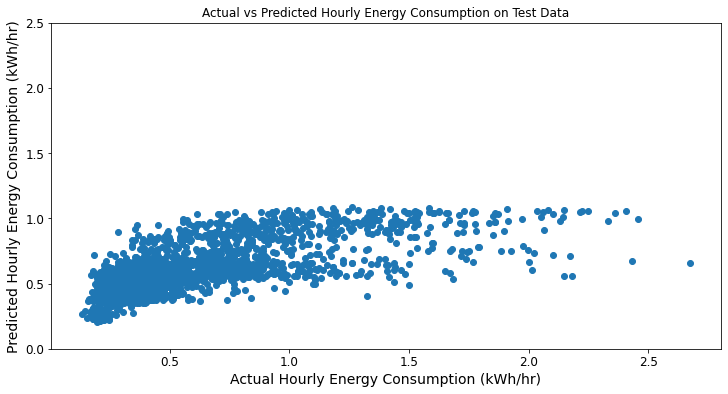

In [145]:
# view test predictions as compared to the actual hourly energy consumption data

plt.figure(figsize=(12,6))
plt.scatter(lr_hourly_predictions_df['energy'],lr_hourly_predictions_df['prediction'])
plt.xlabel("Actual Hourly Energy Consumption (kWh/hr)")
plt.ylabel("Predicted Hourly Energy Consumption (kWh/hr)")
plt.ylim(0,2.5)
plt.title("Actual vs Predicted Hourly Energy Consumption on Test Data")
plt.show()

In [146]:
# view test R2 

lr_hourly_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="energy",
                                        metricName="r2")

lr_hourly_test_r2 = lr_hourly_evaluator.evaluate(lr_hourly_predictions)
print("R Squared (R2) on test data = %.2g" % lr_hourly_test_r2)

R Squared (R2) on test data = 0.45


In [147]:
# view test R2 

lr_hourly_test_result = lr_hourly_model.evaluate(prepared_hourly_test_df)
print("Root Mean Squared Error (RMSE) on test data = %.2g" % 
      lr_hourly_test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.29


#### Decision Tree

In [148]:
# build decision tree model and fit on the training dataset used for linear regression
hourly_dt = DecisionTreeRegressor(featuresCol='features')
hourly_dt_model = hourly_dt.fit(prepared_hourly_train_df)

In [149]:
# making predictions on test dataset

hourly_dt_predictions = hourly_dt_model.transform(prepared_hourly_test_df)
hourly_dt_predictions.select("prediction", "label", "features").show(5)

+-------------------+-------------------+--------------------+
|         prediction|              label|            features|
+-------------------+-------------------+--------------------+
|0.48844852541358047|0.13199999928474426|(54,[0,1,2,8,9,10...|
|0.48844852541358047| 0.1459999978542328|(54,[0,1,3,8,9,11...|
|0.48844852541358047|0.15299999713897705|(54,[0,1,3,8,9,10...|
|0.48844852541358047|0.15800000727176666|(54,[0,1,2,8,9,10...|
|0.48844852541358047|0.16300000250339508|(54,[0,1,3,8,9,10...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [150]:
# Show decision tree performance

# Select (prediction, true label) and compute test error
hourly_dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
hourly_dt_rmse = hourly_dt_evaluator.evaluate(hourly_dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %.2g" % hourly_dt_rmse)

Root Mean Squared Error (RMSE) on test data = 0.31


In [151]:
# View decision tree feature importance
# Check with linear regression index-to-feature mapping to identify features with highest magnitude.

hourly_dt_model.featureImportances

SparseVector(54, {0: 0.0012, 1: 0.0125, 2: 0.0352, 5: 0.0005, 9: 0.0009, 11: 0.0075, 12: 0.0714, 15: 0.0048, 19: 0.0155, 20: 0.0036, 22: 0.0092, 23: 0.0041, 28: 0.0005, 29: 0.0006, 35: 0.1082, 36: 0.2011, 37: 0.1691, 38: 0.1693, 39: 0.1848})

#### Random Forest

In [152]:
# build random forest model and fit on the training dataset used for linear regression

hourly_rf = RandomForestRegressor(featuresCol="features")
hourly_rf_model = hourly_rf.fit(prepared_hourly_train_df)

In [153]:
# making predictions on test dataset

hourly_rf_predictions = hourly_rf_model.transform(prepared_hourly_test_df)
hourly_rf_predictions.select("prediction", "label", "features").show(5)

+-------------------+-------------------+--------------------+
|         prediction|              label|            features|
+-------------------+-------------------+--------------------+
|0.43939069106270195|0.13199999928474426|(54,[0,1,2,8,9,10...|
|0.49021827635947135| 0.1459999978542328|(54,[0,1,3,8,9,11...|
| 0.4021700884896978|0.15299999713897705|(54,[0,1,3,8,9,10...|
| 0.4450608263335571|0.15800000727176666|(54,[0,1,2,8,9,10...|
|0.49021827635947135|0.16300000250339508|(54,[0,1,3,8,9,10...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [154]:
# Show random forest tree performance

# Select (prediction, true label) and compute test error
hourly_rf_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
hourly_rf_rmse = hourly_rf_evaluator.evaluate(hourly_rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %.2g" % hourly_rf_rmse)

Root Mean Squared Error (RMSE) on test data = 0.3


In [155]:
# View random forest feature importance.  
# Check with linear regression index-to-feature mapping to identify features with highest magnitude.

hourly_rf_model.featureImportances

SparseVector(54, {0: 0.0038, 1: 0.0119, 2: 0.0104, 3: 0.0122, 4: 0.0655, 5: 0.0003, 6: 0.0004, 7: 0.0009, 8: 0.0117, 9: 0.0094, 11: 0.0256, 12: 0.044, 13: 0.0095, 14: 0.0144, 15: 0.0016, 16: 0.004, 17: 0.0002, 18: 0.0, 19: 0.0311, 20: 0.0008, 21: 0.0003, 22: 0.002, 23: 0.0005, 24: 0.0003, 25: 0.0017, 26: 0.001, 27: 0.0024, 28: 0.0008, 29: 0.0015, 30: 0.0035, 32: 0.0001, 35: 0.0474, 36: 0.1696, 37: 0.185, 38: 0.1561, 39: 0.1495, 40: 0.008, 41: 0.001, 45: 0.0, 46: 0.0022, 48: 0.0024, 49: 0.0028, 52: 0.004, 53: 0.0005})

#### Gradient Boosted Tree Regression

In [156]:
# build gradient boosted tree model and fit on the training dataset used for linear regression

hourly_gbt = GBTRegressor(featuresCol="features")
hourly_gbt_model = hourly_gbt.fit(prepared_hourly_train_df)

In [157]:
# making predictions on test dataset

hourly_gbt_predictions = hourly_gbt_model.transform(prepared_hourly_test_df)
hourly_gbt_predictions.select("prediction", "label", "features").show(5)

+-------------------+-------------------+--------------------+
|         prediction|              label|            features|
+-------------------+-------------------+--------------------+
| 0.2693043978400851|0.13199999928474426|(54,[0,1,2,8,9,10...|
| 0.2288880997289212| 0.1459999978542328|(54,[0,1,3,8,9,11...|
|0.23100066877841569|0.15299999713897705|(54,[0,1,3,8,9,10...|
| 0.3106264801036512|0.15800000727176666|(54,[0,1,2,8,9,10...|
|0.33202708304816847|0.16300000250339508|(54,[0,1,3,8,9,10...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [158]:
# Show gradient tree performance

# Select (prediction, true label) and compute test error
hourly_gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
hourly_gbt_rmse = hourly_gbt_evaluator.evaluate(hourly_gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %.2g" % hourly_gbt_rmse)

Root Mean Squared Error (RMSE) on test data = 0.26


In [159]:
# View gradient boosted tree feature importance.  
# Check with linear regression index-to-feature mapping to identify features with highest magnitude.

hourly_gbt_model.featureImportances

SparseVector(54, {0: 0.0301, 1: 0.0394, 2: 0.0445, 3: 0.0449, 4: 0.0107, 5: 0.001, 6: 0.0, 7: 0.0002, 8: 0.0252, 9: 0.0242, 11: 0.0487, 12: 0.0884, 13: 0.0358, 14: 0.0391, 15: 0.0097, 16: 0.0124, 17: 0.0016, 18: 0.0116, 19: 0.0643, 20: 0.0005, 22: 0.0555, 23: 0.0021, 24: 0.0015, 25: 0.0001, 26: 0.0044, 27: 0.0012, 28: 0.0026, 29: 0.0015, 30: 0.008, 31: 0.0052, 32: 0.0076, 33: 0.0055, 34: 0.0351, 35: 0.0251, 36: 0.0333, 37: 0.0276, 38: 0.0294, 39: 0.0345, 40: 0.1017, 41: 0.0071, 42: 0.0069, 44: 0.0079, 46: 0.0096, 47: 0.0108, 48: 0.0169, 49: 0.0122, 51: 0.0032, 52: 0.0098, 53: 0.0013})

### Model Summary


In [160]:
# create a table to summarize the results across all models
result_data = {'Overall Daily Model':  [mean_energy_daily, lr_daily_test_r2, lr_daily_test_result.rootMeanSquaredError, daily_dt_rmse, daily_rf_rmse, daily_gbt_rmse],
        'Single Meter Hourly Model': [mean_energy_hourly, lr_hourly_test_r2, lr_hourly_test_result.rootMeanSquaredError, hourly_dt_rmse, hourly_rf_rmse, hourly_gbt_rmse],
        'Model': ['Mean Energy Consumption (kWh or kWh/hr)','Linear Regression Test R2','Linear Regression Test RMSE', 'Decision Tree Test RMSE', 'Random Forest Test RMSE', 'Gradient Boosted Test RMSE'],
              }

model_results = pd.DataFrame(result_data).set_index('Model')

In [161]:
model_results

,Overall Daily Model,Single Meter Hourly Model
Model,,
Mean Energy Consumption (kWh or kWh/hr),10.196622,0.600752
Linear Regression Test R2,0.089387,0.448217
Linear Regression Test RMSE,8.707719,0.285158
Decision Tree Test RMSE,8.750116,0.306728
Random Forest Test RMSE,8.744138,0.303716
Gradient Boosted Test RMSE,8.691600,0.259193
